In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 100
K = 3


def vandermonde(X, K):
    N = len(X)
    vander = np.zeros((N, K))
    for i in range(K):
        vander[:, i] = np.power(X, i)
    return vander


a = 0
b = 1

# corrupt Y with noise
sigma = 0.1

theta_true = np.ones((K,))

# Linspace of X in 0 1
x_train = np.linspace(a, b, N)
# creatopn test set
x_test = np.random.uniform(a, b, N)


In [3]:
def create_dataset(X, X_test, K, theta_true, sigma=0.1):


    # Define Y such that theta true is the solution of phi(x) times thetha  equals Y
    Phi = vandermonde(X, K)
    Y = Phi @ theta_true


    Y = Y +  np.random.normal(0, sigma, Y.shape)


    # Define Y such that theta true is the solution of phi(x) times thetha  equals Y
    Phi_test = vandermonde(X_test, K)
    Y_test = Phi_test @ theta_true
    Y_test = Y_test +  np.random.normal(0, sigma, Y_test.shape)
    return Y, Y_test


In [4]:
def mle_normal_equation(D, K):
    Phi, Y = D
    b = Phi.T@Y
    try:
        L = np.linalg.cholesky(Phi.T@Phi)
        y = np.linalg.solve(L, b)
        theta = np.linalg.solve(L.T, y)
    except:
        theta = np.linalg.solve(Phi.T @ Phi, Phi.T @ Y)
    return theta

In [5]:


def backtracking(f, grad_f, x):
    """
    This function is a simple implementation of the backtracking algorithm for
    the GD (Gradient Descent) method.

    f: function. The function that we want to optimize.
    grad_f: function. The gradient of f(x).
    x: ndarray. The actual iterate x_k.
    """
    alpha = 1
    c = 0.8
    tau = 0.25
    while f(x - alpha * grad_f(x)) > f(x) - c * alpha * np.linalg.norm(grad_f(x), 2) ** 2:
        alpha = tau * alpha

        if alpha < 1e-3:
            break
    return alpha



def GD(f, grad_f, x0, tolf, tolx, kmax=1000, alpha=1e-2, back=True):

    shape = (kmax, *x0.shape)
    # output
    x = np.zeros(shape)
    f_val = np.zeros((kmax, 1))
    grads = np.zeros((kmax, 1, x0.shape[0]))
    err = np.zeros((kmax, 1))

    x_tol = tolx
    f_tol = tolf
    x_old = x0
    k = 0

    while k < kmax and x_tol >= tolx and f_tol >= tolf:
        if back:
            alpha = backtracking(f, grad_f, x_old)
        x_k = x_old - alpha * grad_f(x_old)
        x_tol = np.linalg.norm(x_k-x_old)
        f_tol = np.linalg.norm(f(x_k))

        # Update arrays
        x[k] = x_k
        f_val[k] = f(x_k)
        grads[k] = grad_f(x_k)
        err[k] = np.linalg.norm(grads[k])
        x_old = x_k
        k = k+1

    return x[:k], f_val[:k], grads[:k], err[:k]

In [6]:
batch_size = 10


def batch(x, y, batch_size):
    n = x.shape[0]
    idx = np.arange(n)
    np.random.shuffle(idx)
    n_batches = n // batch_size
    for i in range(n_batches):
        batch_index = idx[i*batch_size:(i+1)*batch_size]
        yield x[batch_index, :], y[batch_index]


def SGD(l, grad_l, w0, data, batch_size, n_epochs=5):

    shape = (n_epochs, *w0.shape)
    x_, y_ = data
    d, n = x_.shape
    w = np.zeros(shape)
    f_val = np.zeros((n_epochs, 1))
    grads = np.zeros((n_epochs, 1, w0.shape[0]))
    err = np.zeros((n_epochs, 1))

    #print("W0 shape: ", w0.shape)
    alpha = 1e-5
    w_old = w0
    w_k = w_old

    for epoch in range(n_epochs):
        batch_iterator = batch(x_, y_, batch_size)
        for x, y in batch_iterator:
            grad = grad_l(w_old, x, y)
            w_k = w_old - alpha * grad
            w_old = w_k
        w[epoch] = w_k
        f_val[epoch] = l(w_k, x_, y_)
        grads[epoch] = grad_l(w_k, x_, y_)
        err[epoch] = np.linalg.norm(grads[epoch], 2)
    return w, f_val, grads, err


In [7]:
def error(D, theta):
    x_test, y_test = D
    Ntest = len(x_test)
    y_pred = x_test @ theta
    accuracy = np.linalg.norm(y_test-y_pred)**2 / Ntest
    return accuracy

In [8]:
def plot(x_train, y_train, x_test, y_test, theta, K, title="Normal"):
    plt.figure(figsize=(10, 10))
    plt.plot(x_train, y_train, "ro")
    plt.plot(x_test, y_test, "yo")
    XX = np.linspace(a, b, 10000)
    YY = vandermonde(XX, K) @ theta
    err = error((vandermonde(x_test, K), y_test), theta)
    plt.title(f"{title} MLE with K={K} and error={round(err,4)}")
    plt.plot(XX, YY)
    plt.legend(["Train test", "Test set", f"{title} regressor"])
    plt.show()

In [9]:
# datasets
y_train, y_test = create_dataset(x_train, x_test, K, np.ones((K,)))

phi_train = vandermonde(x_train, K)
phi_test = vandermonde(x_test, K)


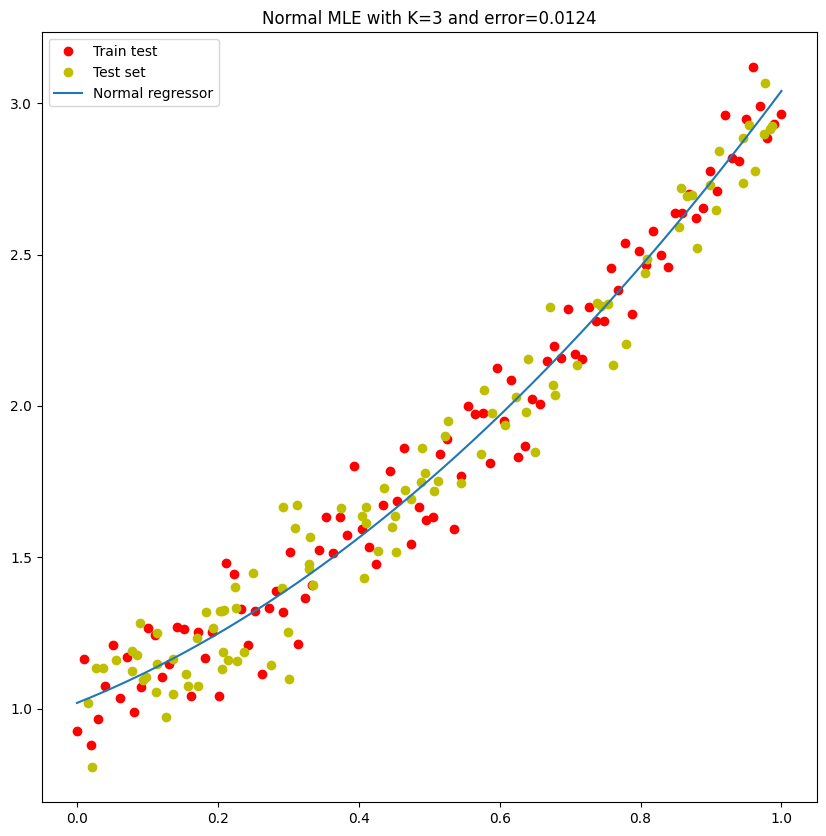

In [10]:

def f_gen(phi, y, sigma, sgd=False):
    if not sgd:
        def f(theta):
            return 1/(2*sigma) * np.linalg.norm(y-(phi@theta))**2
        return f
    else:
        def f1(theta, phi, y):
            return 1/(2*sigma) * np.linalg.norm(y-phi@theta)**2
        return f1


def grad_gen(phi, y, sigma, sgd=False):
    if not sgd:
        def grad_f(theta):
            return phi.T @ (((phi)@theta) - y)
        return grad_f
    else:
        def grad_f1(theta, phi, y):
            return phi.T @ (((phi)@theta) - y)
        return grad_f1


# GD
tolf = 1e-4
tolx = 1e-4
kmax = 100


f = f_gen(phi_train, y_train, sigma)
grad_f = grad_gen(phi_train, y_train, sigma)

theta_0 = np.zeros((K,))
thetas, _, _, _  = GD(f, grad_f, theta_0, tolf, tolx, back=True)
theta_gd = thetas[-1]
#print(theta_gd)
plot(x_train, y_train, x_test, y_test, theta_gd, K)


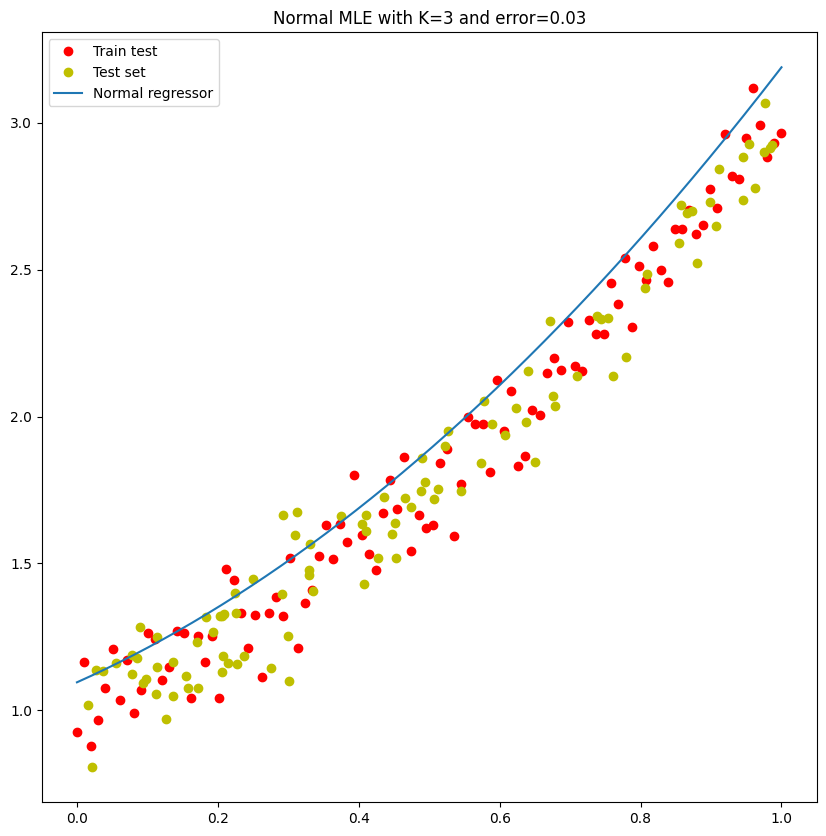

In [11]:
f_sgd = f_gen(phi_train, y_train, sigma, sgd=True)
grad_f_sgd = grad_gen(phi_train, y_train, sigma, sgd=True)
theta_0 = np.random.normal(1, sigma, (K, ))
#theta_0 = np.zeros((K, ))
w, f_val, grads, err = SGD(f_sgd, grad_f_sgd, theta_0, (phi_train, y_train), 25, 20)
theta_sgd = w[-1]
plot(x_train, y_train, x_test, y_test, theta_sgd, K)


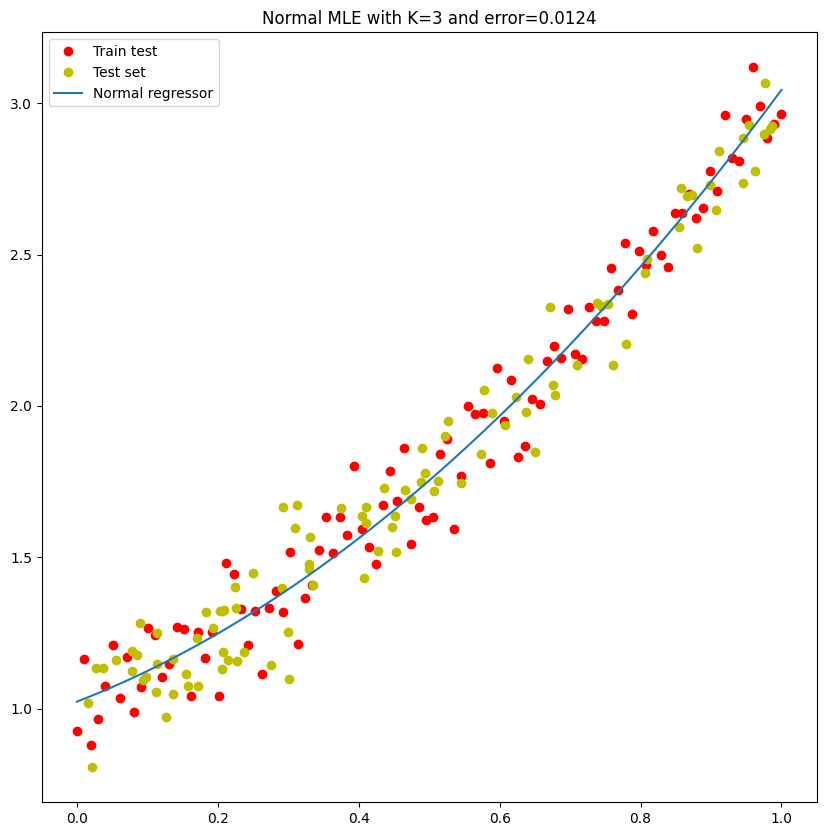

In [12]:

theta = mle_normal_equation((phi_train, y_train), K)
plot(x_train, y_train, x_test, y_test, theta, K)   

In [13]:
def mle_gd(x_train, y_train, K):
    phi_train = vandermonde(x_train, K)
    f = f_gen(phi_train, y_train, sigma)
    grad_f = grad_gen(phi_train, y_train, sigma)

    theta_0 = np.zeros((K, ))
    thetas, _, _, _ = GD(f, grad_f, theta_0, tolf, tolx, kmax, back=True)
    theta_gd = thetas[-1]
    return theta_gd
def mle_sgd(x_train, y_train, K):

    phi_train = vandermonde(x_train, K)
    f_sgd = f_gen(phi_train, y_train, sigma, sgd=True)
    grad_f_sgd = grad_gen(phi_train, y_train, sigma, sgd=True)
    theta_0 = np.random.normal(1, sigma, (K, ))
    w, f_val, grads, err = SGD(f_sgd, grad_f_sgd, theta_0,
                            (phi_train, y_train), 25, 20)
    theta_sgd = w[-1]
    return theta_sgd
def mle_normal(x_train, y_train, K):
    phi_train = vandermonde(x_train, K)
    return mle_normal_equation((phi_train, y_train), K)

In [14]:
def plot_errors(err_normal, err_gd, err_sgd, grades):
    
    figure = plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.title("Error on train set")
    plt.plot(grades, err_normal["train"])
    plt.plot(grades, err_gd["train"])
    plt.plot(grades, err_sgd["train"])
    plt.legend(["Normal equation", "GD", "SGD"])
    plt.subplot(1, 2, 2)
    plt.title("Error on test set")
    plt.plot(grades, err_normal["test"])
    plt.plot(grades, err_gd["test"])
    plt.plot(grades, err_sgd["test"])
    plt.xlabel("Grades")
    plt.ylabel("Error")
    plt.legend(["Normal equation", "GD", "SGD"])

    plt.show()


In [15]:
def plot_regressor(x_train, y_train, x_test, y_test, thetas, grades,  method="MLE"):
    plt.figure(figsize=(20, 30))
    total = len(grades)
    thetas_normal, thetas_gd, thetas_sgd = thetas
    cols = 2
    row = (total // cols) + 1
    for i in range(total):
        plt.subplot(row, cols, i+1)
        plt.plot(x_train, y_train, "ro")
        plt.plot(x_test, y_test, "yo")
        XX = np.linspace(a, b, 10000)
        YY = vandermonde(XX, grades[i]) 
        plt.title(f"{method} with K={grades[i]}")
        plt.plot(XX, YY @ thetas_normal[i])
        plt.plot(XX, YY @ thetas_gd[i])
        plt.plot(XX, YY @ thetas_sgd[i])
        plt.ylim(top=max([max(y_train),max(y_test)]) + 0.5)
        plt.legend(["Train test", "Test set", "Normal eq.", "GD", "SGD"])
    plt.show()


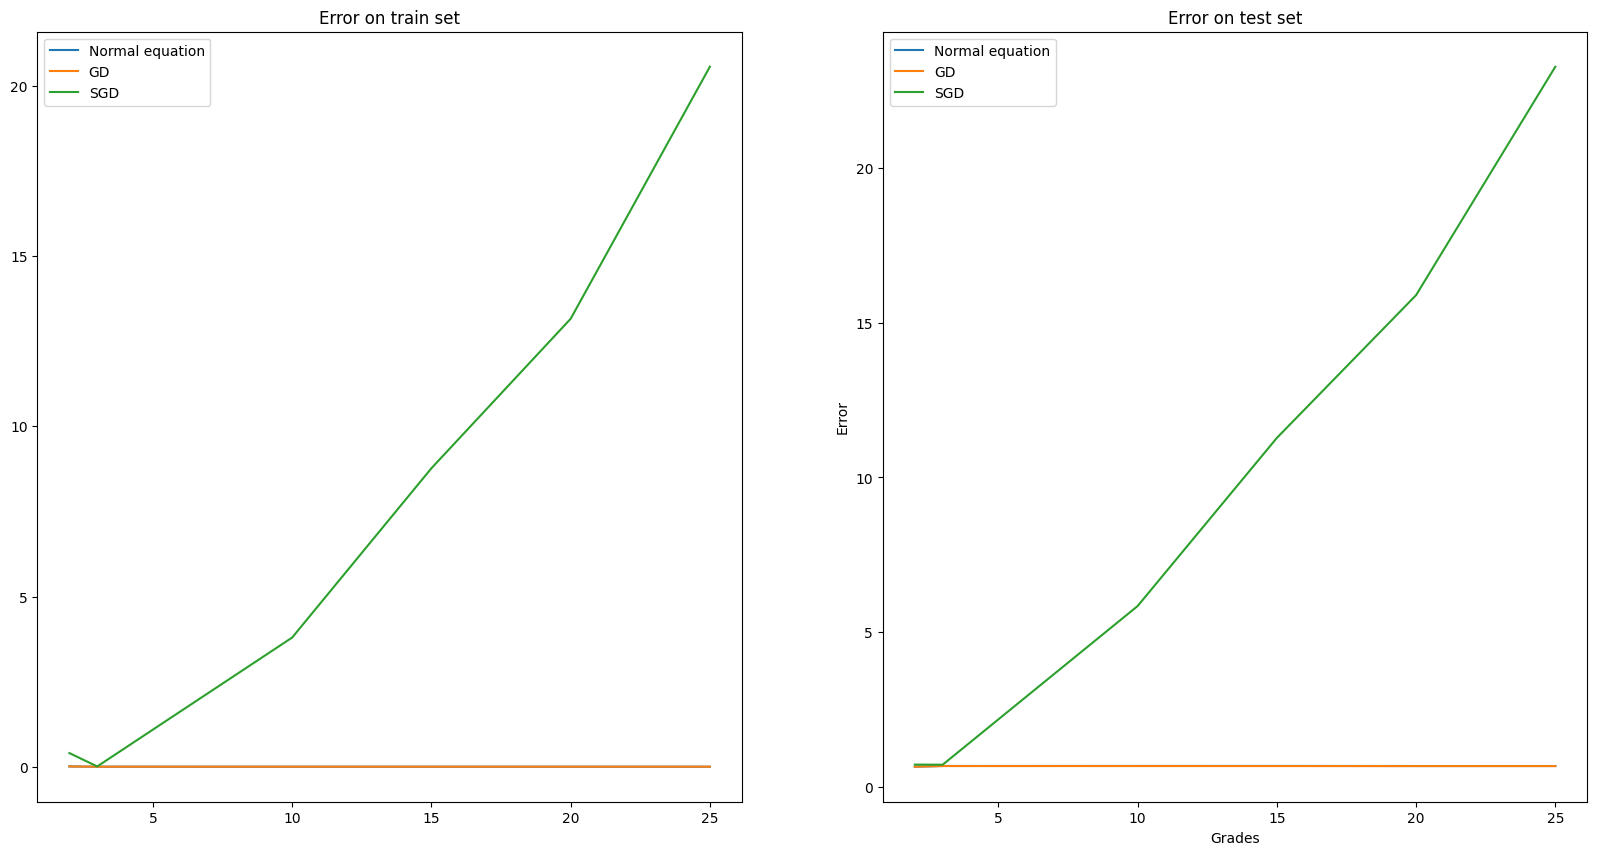

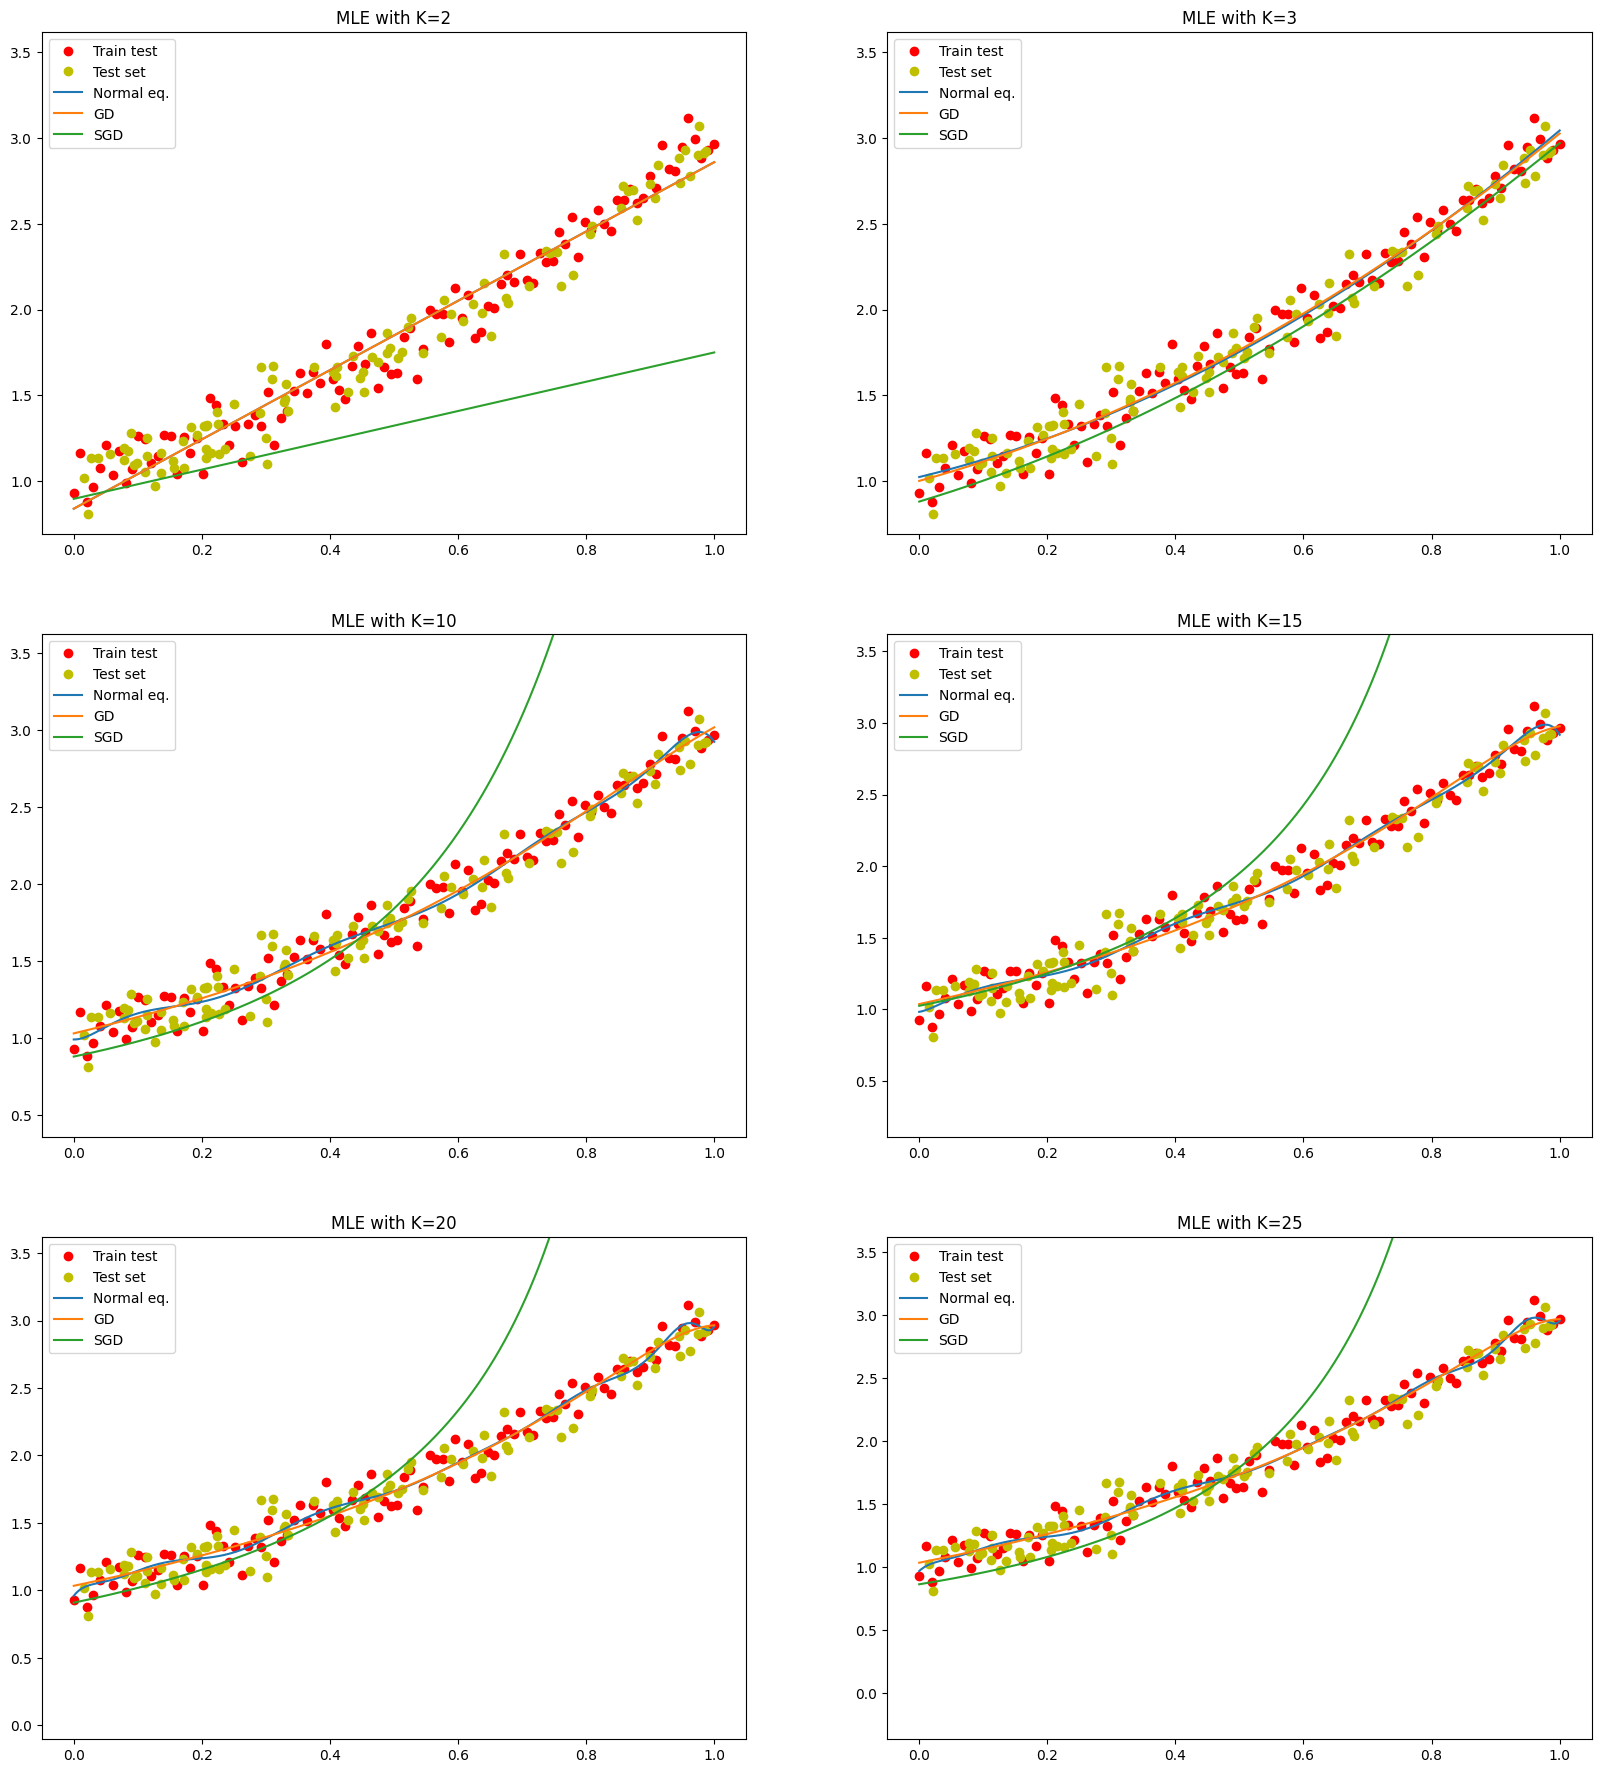

In [16]:
grades = [2, 3, 10, 15, 20, 25]
err_normal = {"train": [], "test": []}
err_gd = {"train": [], "test": []}
err_sgd = {"train": [], "test": []}

thetas_normal = []
thetas_gd = []
thetas_sgd = []


for K in grades:
    theta_true = np.ones((K,))
    theta_0 = np.zeros((K, ))
    #y_train, y_test = create_dataset(x_train, x_test, K, theta_true)

    phi_train = vandermonde(x_train, K)
    phi_test = vandermonde(x_test, K)


    theta_normal = mle_normal(x_train, y_train, K)
    theta_gd = mle_gd(x_train, y_train, K)
    theta_sgd = mle_sgd(x_train, y_train, K)

    thetas_normal.append(theta_normal)
    thetas_gd.append(theta_gd)
    thetas_sgd.append(theta_sgd)


    err_normal["train"].append(error((phi_train, y_train), theta_normal))
    err_normal["test"].append(error((phi_test, y_train), theta_normal))

    err_gd["train"].append(error((phi_train, y_train), theta_gd))
    err_gd["test"].append(error((phi_test, y_train), theta_gd))

    err_sgd["train"].append(error((phi_train, y_train), theta_sgd))
    err_sgd["test"].append(error((phi_test, y_train), theta_sgd))
        
    #plot(x_train, y_train, x_test, y_test, theta_normal, K, title="Normal")
    #plot(x_train, y_train, x_test, y_test, theta_gd, K, title="GD")
    #plot(x_train, y_train, x_test, y_test, theta_sgd, K, title="SGD")

plot_errors(err_normal, err_gd, err_sgd, grades)
plot_regressor(x_train, y_train, x_test, y_test,
               (thetas_normal, thetas_gd, thetas_sgd), grades)


**MAP**

In [17]:

def f_map_gen(phi, y, lmb=1,sgd=False):
    if not sgd:
        def f(theta):
            return lmb * np.linalg.norm(theta) + np.linalg.norm(y-phi@theta)**2
        return f
    else:
        def f1(theta, phi, y):
            return lmb * np.linalg.norm(theta) + np.linalg.norm(y-phi@theta)**2
        return f1


def grad_map_gen(phi, y, lmb=1, sgd=False):
    if not sgd:
        def grad_f(theta):
            return (((theta.T@phi.T@phi)-(y.T@phi)) + (2*lmb)*theta)
        return grad_f
    else:
        def grad_f1(theta, phi, y):
            return ((theta.T@phi.T@phi-y.T@phi) + (2*lmb)*theta.T)
        return grad_f1




def map_normal(x, y, K, lmb):
    phi = vandermonde(x, K)
    b = phi.T@y
    A = phi.T@phi + (lmb * np.identity(K))
    L = np.linalg.cholesky(A)
    y = np.linalg.solve(L, b)
    theta = np.linalg.solve(L.T, y)
    return theta

def map_gd(x_train, y_train, K, lmb=1):
    phi_train = vandermonde(x_train, K)
    f = f_map_gen(phi_train, y_train, lmb=lmb)
    grad_f = grad_map_gen(phi_train, y_train, lmb=lmb)
    x0 = np.zeros((K, ))
    theta_gd , _, _, _= GD(f, grad_f, x0, tolf, tolx, kmax)
    theta_gd = theta_gd[-1]
    return theta_gd

def map_sgd(x_train, y_train, K, lmb=1):
    phi_train = vandermonde(x_train, K)
    f = f_map_gen(phi_train, y_train, sgd=True, lmb=lmb)
    grad_f = grad_map_gen(phi_train, y_train, sgd=True, lmb=lmb)
    x0 = np.random.normal(1, sigma, (K,))
    theta_sgd , _, _, _= SGD(f, grad_f, x0, (phi_train, y_train), batch_size=20)
    theta_sgd = theta_sgd[-1]
    return theta_sgd




In [18]:
def plot_regressor_lmb(x_train, y_train, x_test, y_test, thetas, grades, lmb, title="Normal"):
    plt.figure(figsize=(30, 10))
    total = len(grades)
    thetas_normal, thetas_gd, thetas_sgd = thetas
    cols = len(grades)
    row = 1
    for i in range(cols):
        plt.subplot(row, cols, i+1)
        plt.plot(x_train, y_train, "ro")
        plt.plot(x_test, y_test, "yo")
        XX = np.linspace(a, b, 10000)
        YY = vandermonde(XX, grades[i])
        plt.title(f"{title} MAP with K={grades[i]} and lmb={lmb}")
        plt.plot(XX, YY @ thetas_normal[i])
        plt.plot(XX, YY @ thetas_gd[i])
        plt.plot(XX, YY @ thetas_sgd[i])
        plt.ylim(top=max([max(y_train), max(y_test)]) + 0.5)
        plt.legend(["Train test", "Test set", "Normal eq.", "GD", "SGD"])
    plt.show()


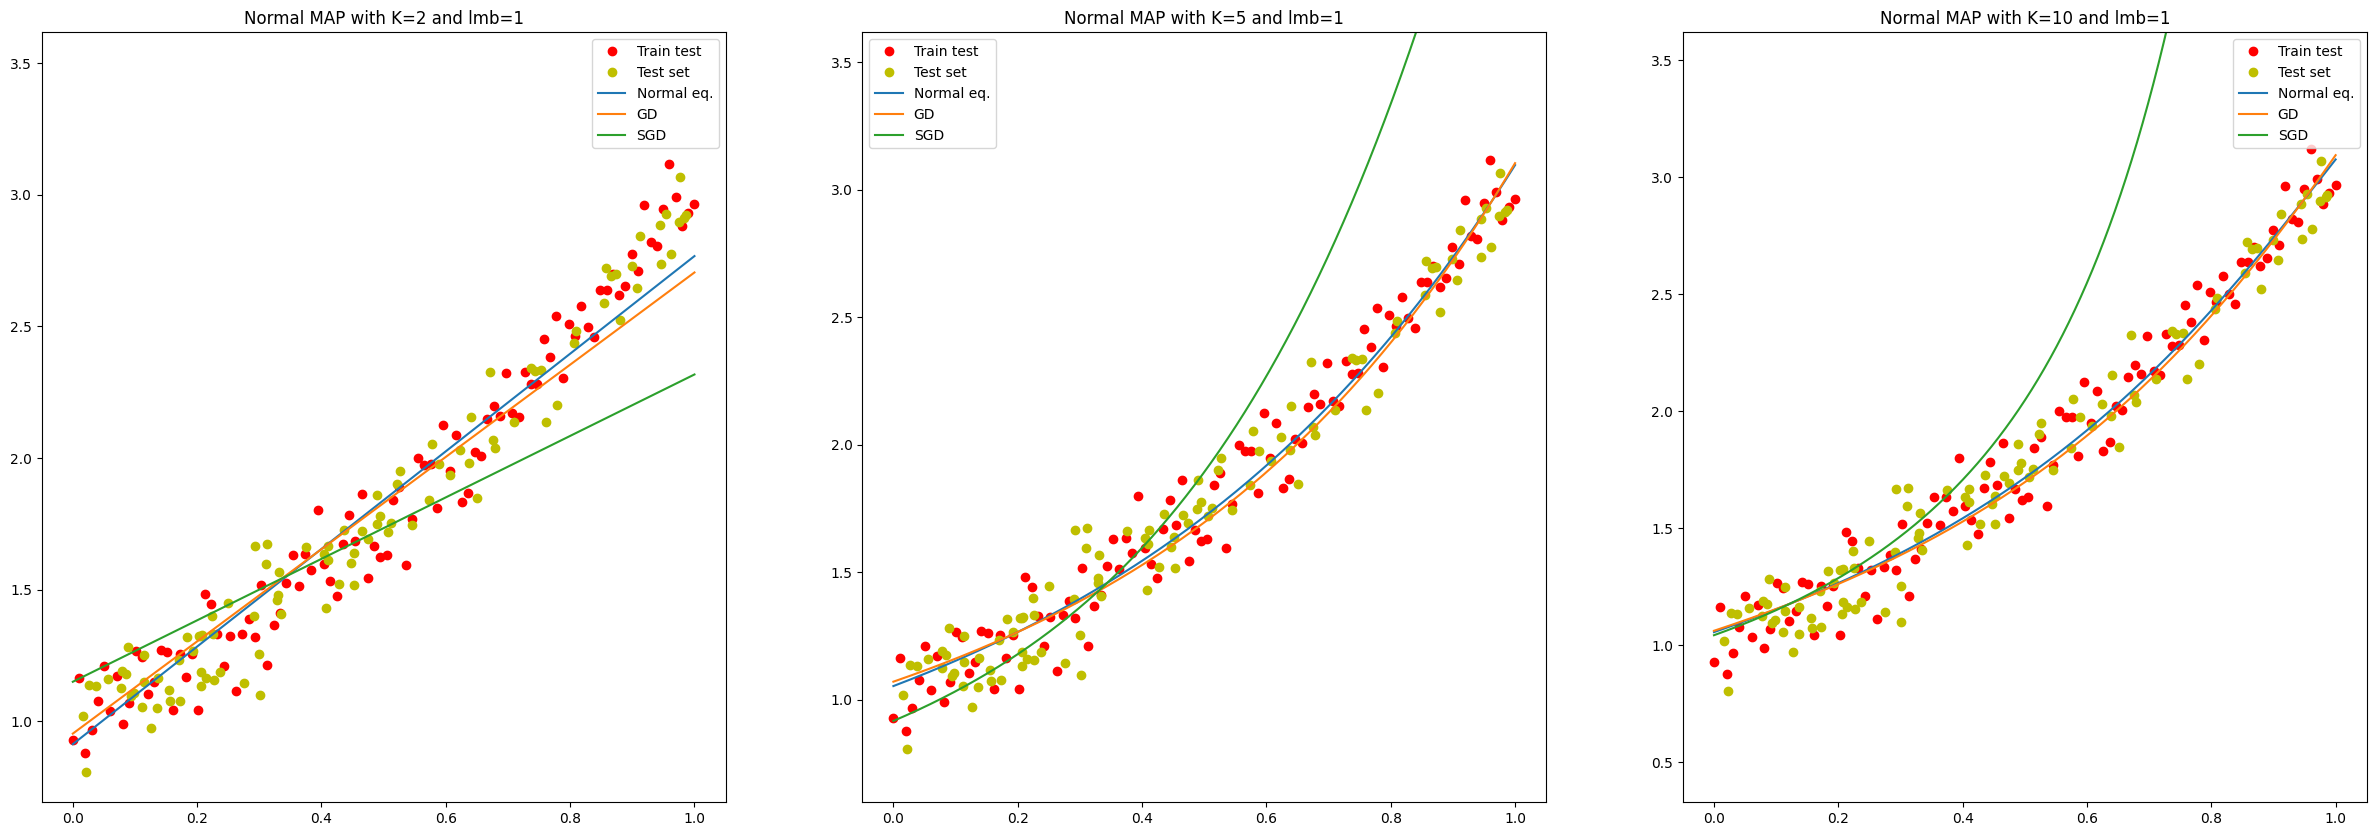

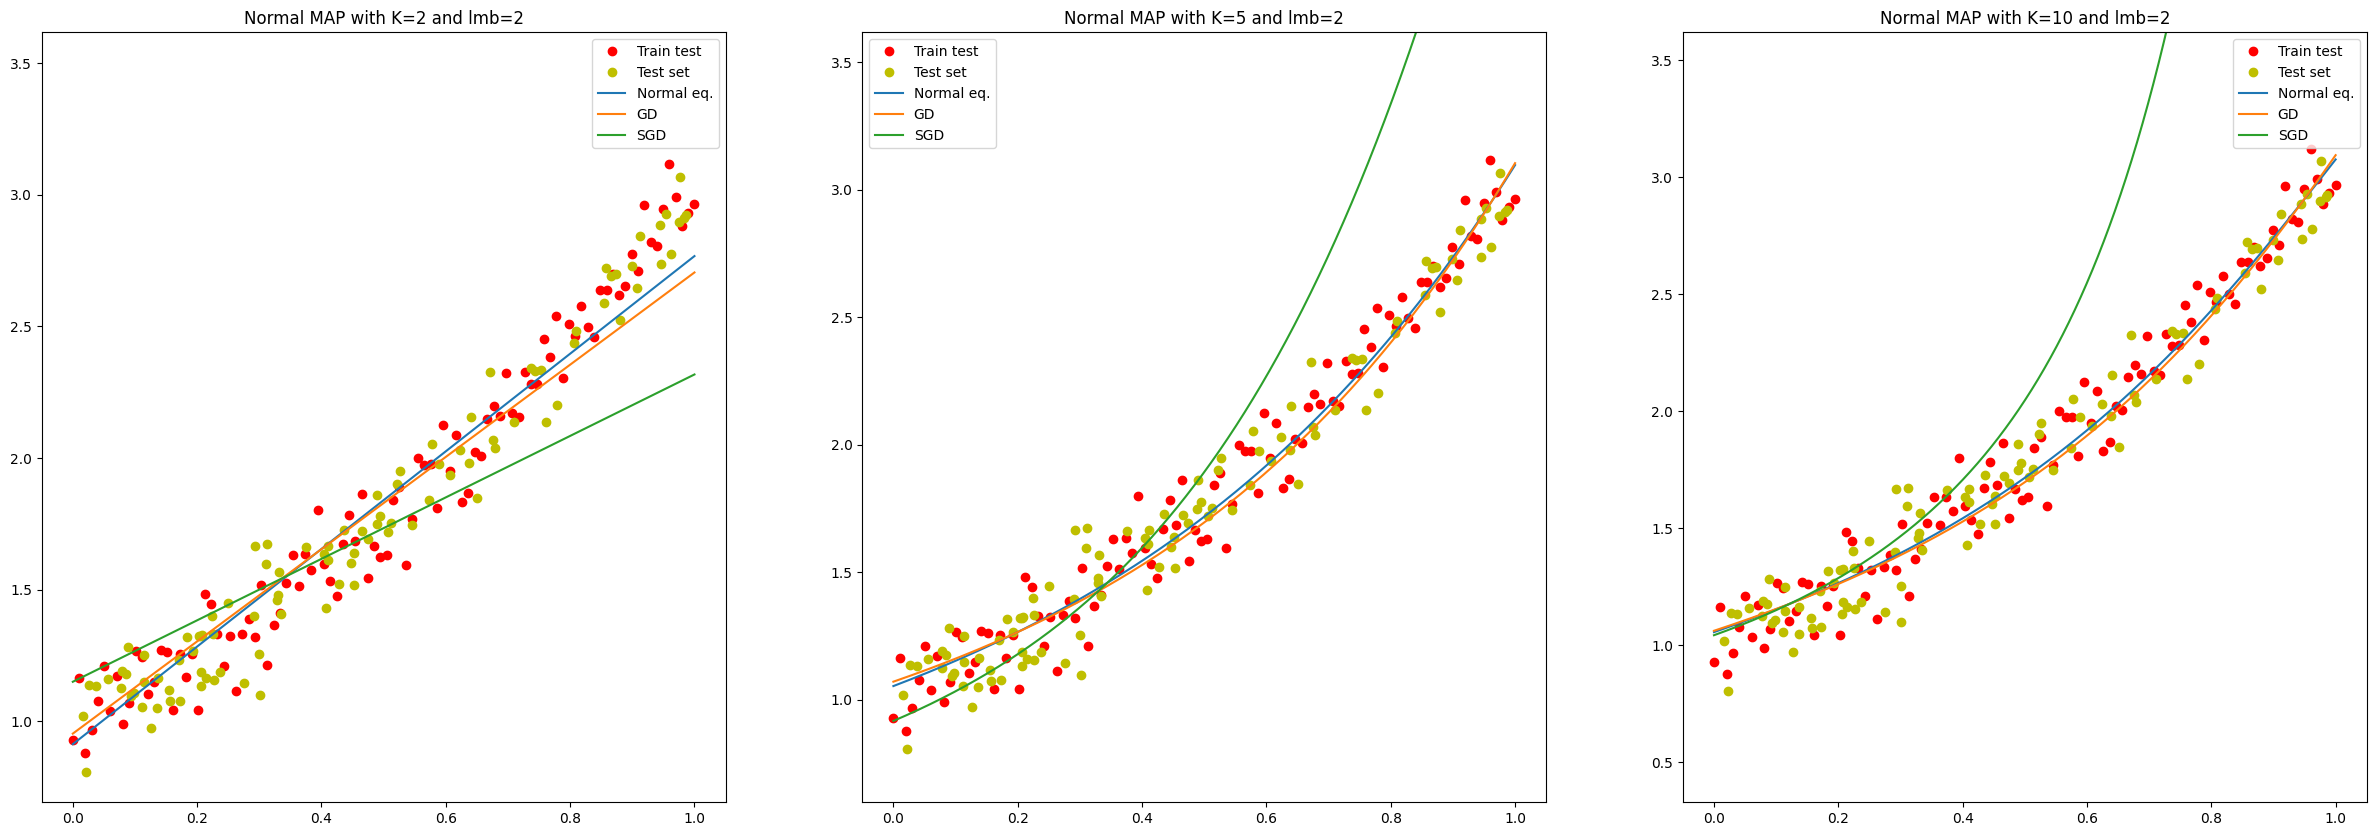

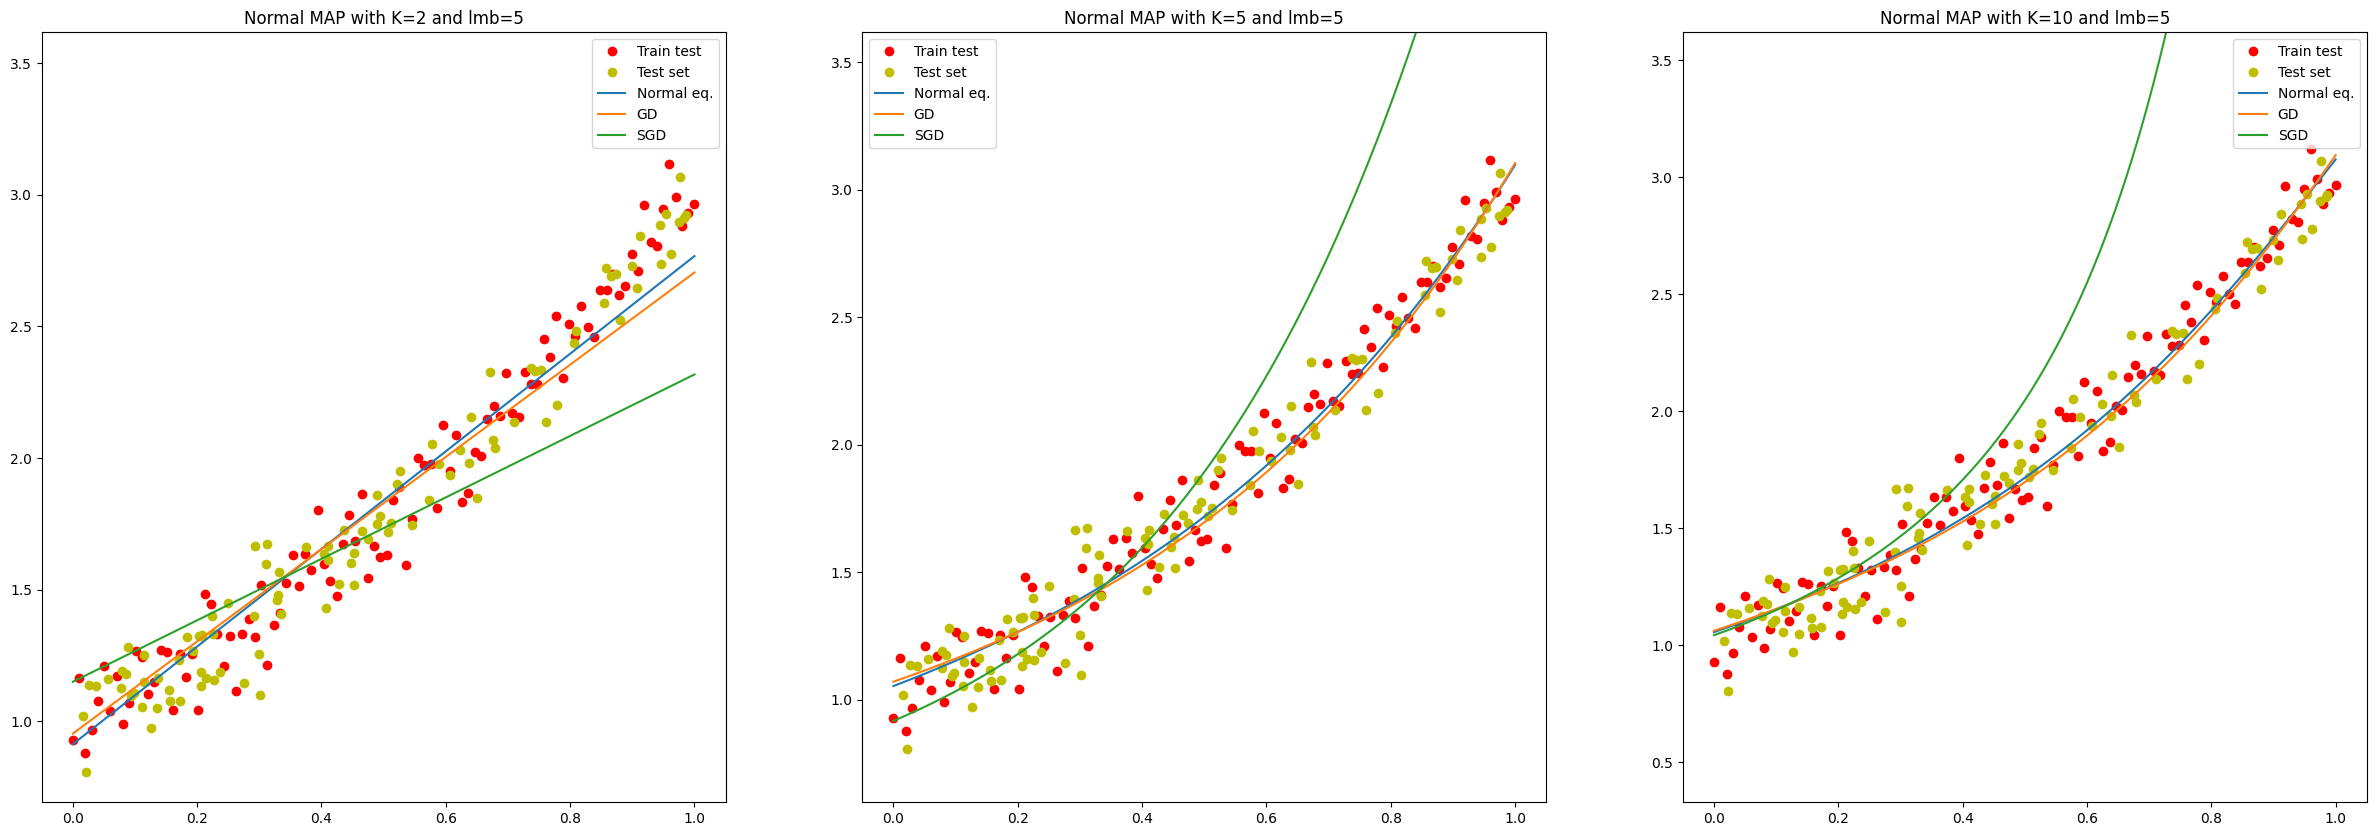

In [19]:
grades = [2, 5, 10]
#err_normal = {"train": [], "test": []}
#err_gd = {"train": [], "test": []}
#err_sgd = {"train": [], "test": []}

thetas_normal = []
thetas_gd = []
thetas_sgd = []

lambdas = [1, 2, 5]
for lmb in lambdas:
    for K in grades:
        theta_true = np.ones((K,))
        theta_0 = np.zeros((K, 1))
        #y_train, y_test = create_dataset(x_train, x_test, K, theta_true)

        phi_train = vandermonde(x_train, K)
        phi_test = vandermonde(x_test, K)

        theta_normal = map_normal(x_train, y_train, K, lmb)
        theta_gd = map_gd(x_train, y_train, K, lmb)
        theta_sgd = map_sgd(x_train, y_train, K, lmb)

        thetas_normal.append(theta_normal)
        thetas_gd.append(theta_gd)
        thetas_sgd.append(theta_sgd)

    plot_regressor_lmb(x_train, y_train, x_test, y_test, (thetas_normal, thetas_gd, thetas_sgd), grades, lmb)


## Big K values ##

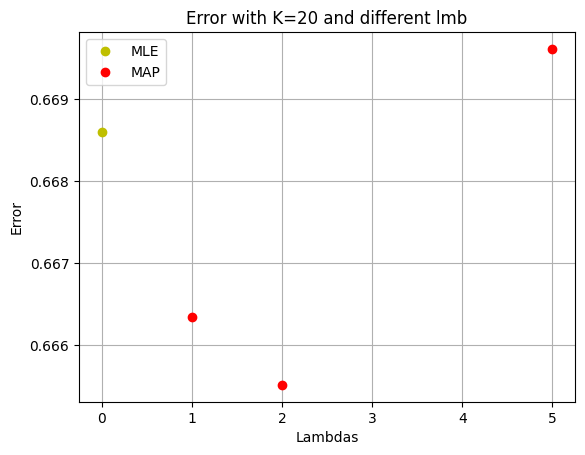

In [20]:
K = 20
lambdas = [1, 2, 5]

err_normal = {"train": [], "test": []}

theta_true = np.ones((K,))
theta_0 = np.zeros((K, 1))
#y_train, y_test = create_dataset(x_train, x_test, K, theta_true)

phi_train = vandermonde(x_train, K)
phi_test = vandermonde(x_test, K)

theta_mle = mle_gd(x_train, y_train, K)
err_mle = error((phi_test, y_train), theta_mle)

for lmb in lambdas:

    theta_normal = map_normal(x_train, y_train, K, lmb)

    err_normal["train"].append(error((phi_train, y_train), theta_normal))
    err_normal["test"].append(error((phi_test, y_train), theta_normal))


plt.plot(0, err_mle, "yo")
plt.plot(lambdas, err_normal["test"], "ro")
plt.xlabel("Lambdas")
plt.ylabel("Error")
plt.title(f"Error with K={K} and different lmb")
plt.grid()
plt.legend(["MLE", "MAP"])


In [21]:
def error_theta(theta, theta_true):
    return np.linalg.norm(theta-theta_true)/np.linalg.norm(theta_true)

In [22]:
def plot_regressor_theta(errors, grades, lmb, title="Normal"):
    plt.figure(figsize=(20, 10))
    err_normal, err_gd, err_sgd, err_mle = errors
    plt.plot(grades, err_normal)
    plt.plot(grades, err_gd)
    plt.plot(grades, err_sgd)
    plt.plot(grades, err_mle)
    plt.title(f"{title} MAP lmb={lmb}")
    plt.legend(["Normal eq.", "GD", "SGD", "MLE"])
    plt.show()



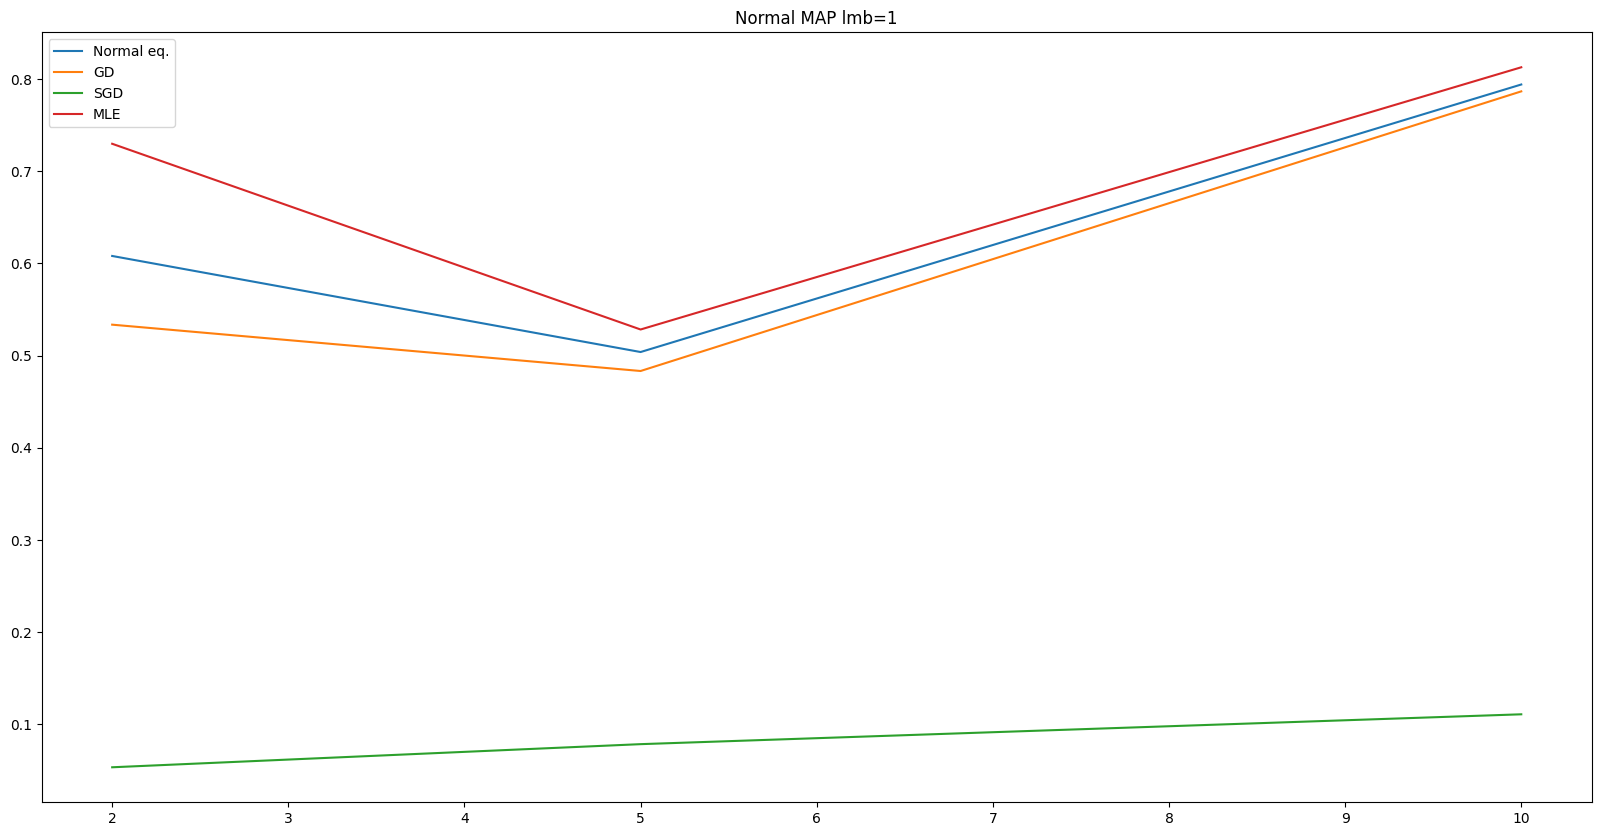

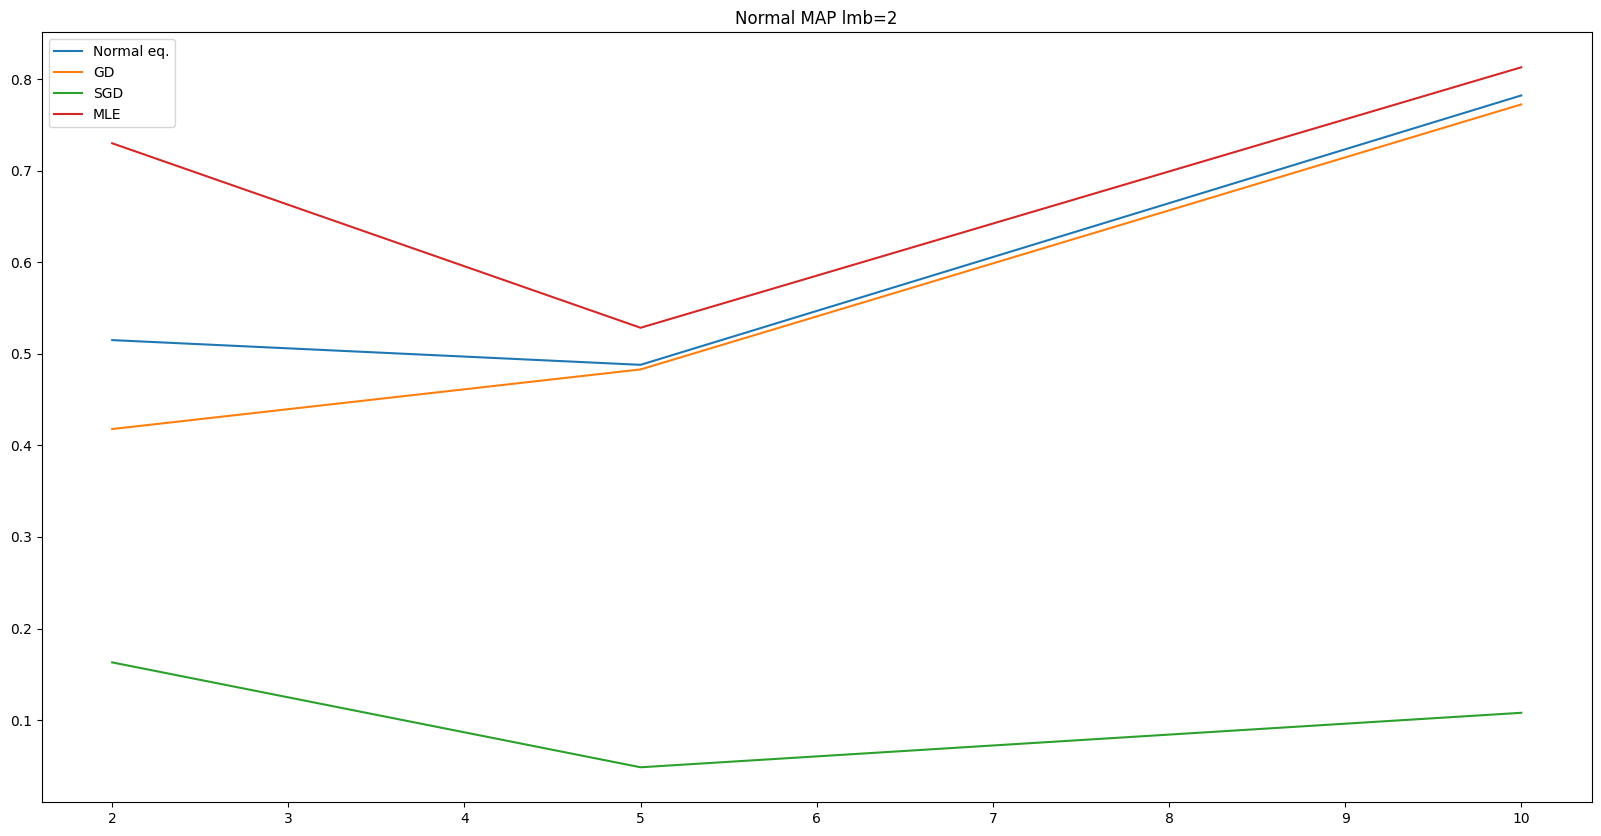

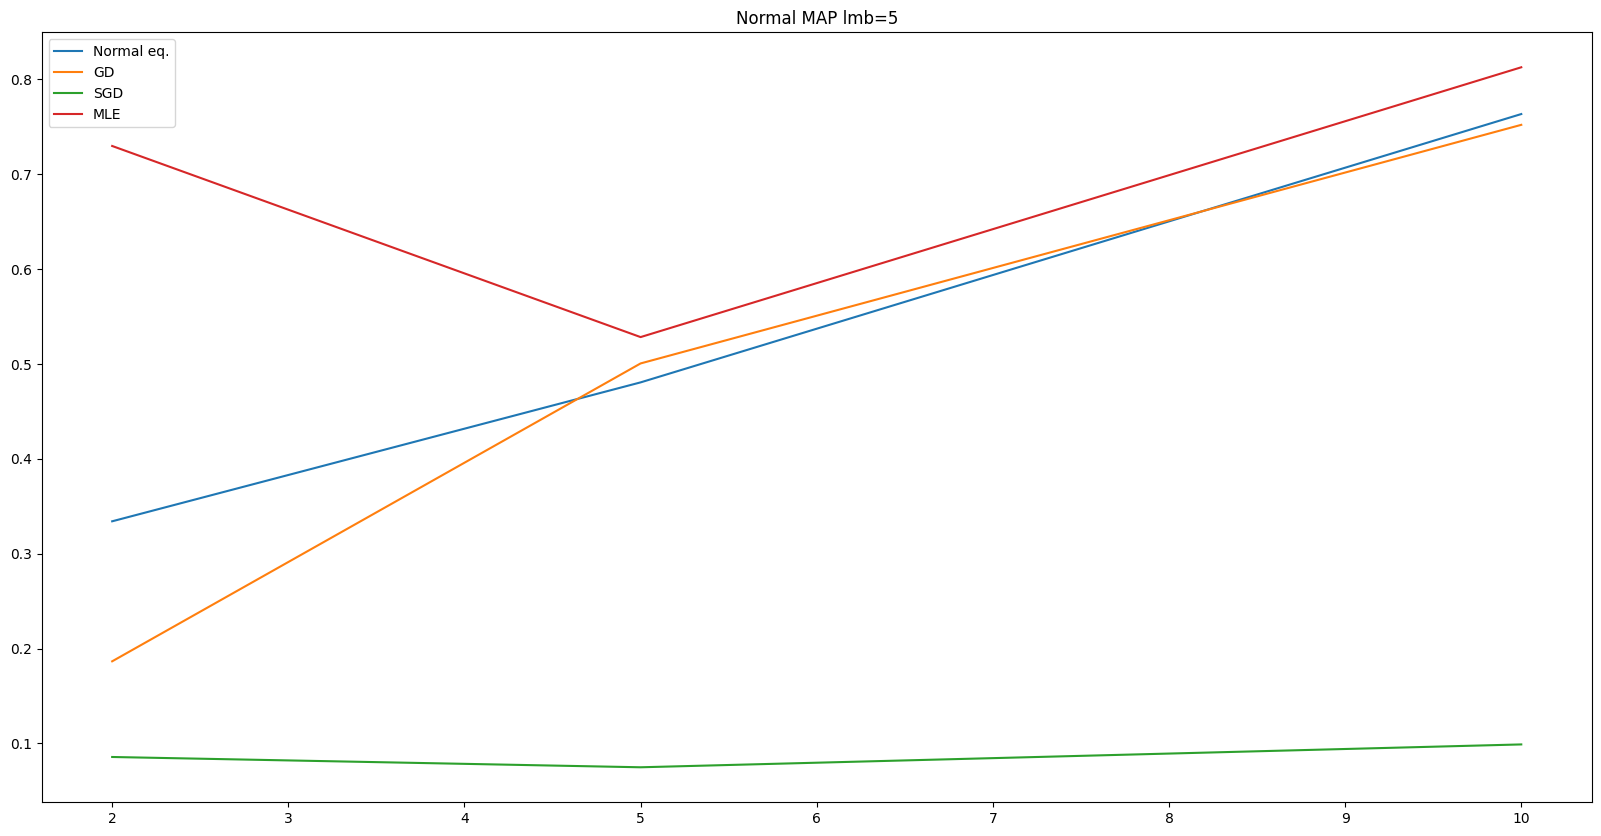

In [23]:
grades = [2, 5, 10]



lambdas = [1, 2, 5]
for lmb in lambdas:
    err_normal = []
    err_gd = []
    err_sgd = []
    err_mle = []
    for K in grades:
        theta_true = np.ones((K,))
        theta_0 = np.zeros((K, 1))
        #y_train, y_test = create_dataset(x_train, x_test, K, theta_true)

        phi_train = vandermonde(x_train, K)
        phi_test = vandermonde(x_test, K)
        theta_mle = mle_gd(x_train, y_train, K)

        err_mle.append(error_theta(theta_mle, theta_true))

        theta_normal = map_normal(x_train, y_train, K, lmb)
        theta_gd = map_gd(x_train, y_train, K, lmb)
        theta_sgd = map_sgd(x_train, y_train, K, lmb)

        err_normal.append(error_theta(theta_normal, theta_true))
        err_gd.append(error_theta(theta_gd, theta_true))
        err_sgd.append(error_theta(theta_sgd, theta_true))


    plot_regressor_theta((err_normal, err_gd, err_sgd, err_mle), grades, lmb)
